In [1]:
from torchfunction.device import AutoDevice as device
from torchfunction.utils import tonumpy as tn
import torch
from matplotlib import pyplot as plt
import tqdm
from tqdm import trange, tqdm
import matplotlib as mpl
import torch.nn as nn
import math
import scipy
import numpy as np
import scipy.stats as stats
from dataset import get_standard_spike_input, get_spike_input, get_random_input
from toolfunc import power_method_batch

from zytlib import path, vector

import matplotlib as mpl
dcolor = mpl.rcParams["axes.prop_cycle"].by_key()['color']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

torch.set_printoptions(precision=2, sci_mode=False, linewidth=140, profile="short")
%config InlineBackend.figure_format = "retina"

[0.04967428571428571, 0.05558285714285714, 0.08137142857142857, 0.06748, 0.06834285714285715, 0.060925714285714284, 0.08068857142857143, 0.05507142857142857]
Using GPU device 4...


In [2]:
from model import lowrank_encoder
from dataset import get_spike_input

In [3]:
def np_str(v, p=3):
    if isinstance(v, float):
        return eval("f'{v:." + str(p) + "g}'")
        # return f"{v:.3g}"
    return [eval("f'{x:." + str(p) + "g}'") for x in tn(v)]
def save_figure(name, path=None, dpi=300, format="jpg"):
    if isinstance(format, (list, tuple)):
        for f in format:
            save_figure(name, path=path, dpi=dpi, format=f)
        return
    if path is None:
        plt.savefig(figure_path / "{}.{}".format(name, format), format=format, dpi=dpi)
    else:
        p = (figure_path / path).mkdir()
        plt.savefig(p / "{}.{}".format(name, format), format=format, dpi=dpi)
figure_path = path("figure/Figure1/").mkdir()

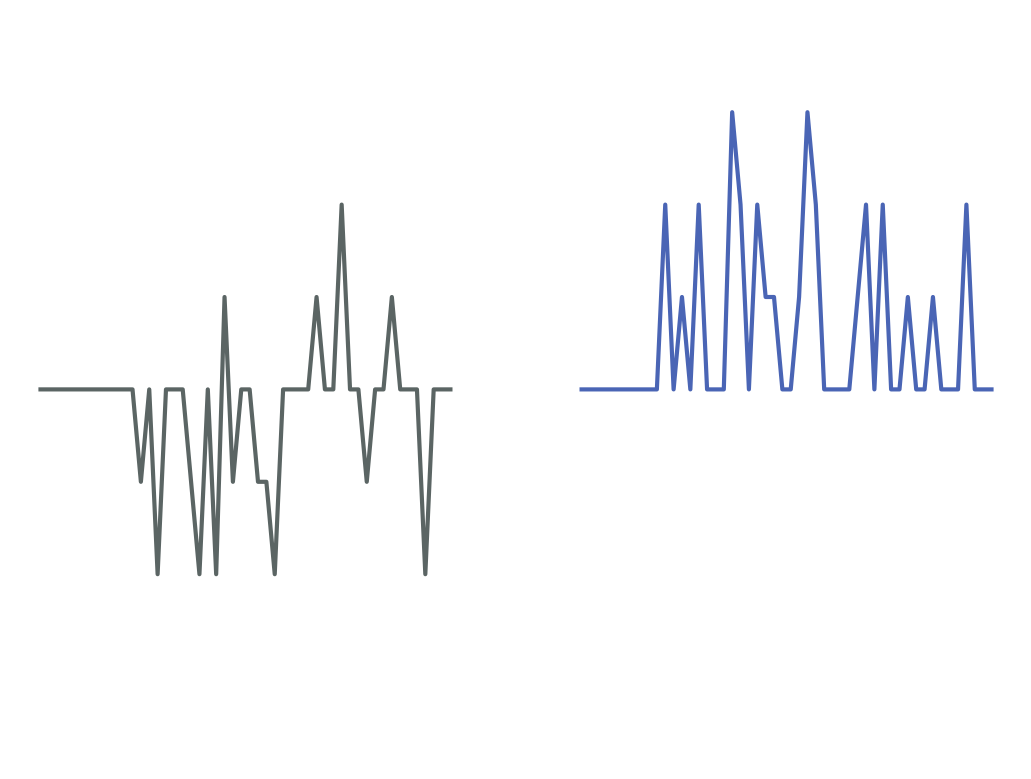

In [4]:
mod_color = ["#5B6564", "#4A65B5"]

torch.manual_seed(10)
input_tensor = get_spike_input(1, fixed_t=10)[0]
fig, axs = plt.subplots(1, 2)
for r in range(2):
    ax = axs[r]
    ax.plot(tn(input_tensor[0, :, r]), color=mod_color[r])
    ax.set_ylim(-0.4, 0.4)
    ax.axis("off")

save_figure("stimulus input example", format="pdf")

In [5]:
# all_loaded = torch.load("rank1-rnns.pt")
all_loaded = list()
for node in ["node01", "node03"]:
    for num in range(50):
        file_name = path(f"lowrank_rnn512_r1_f10/{node}_{num}.pt")
        loaded = torch.load(file_name, map_location="cpu")
        all_loaded.append(loaded)

In [6]:
def print_dict_shapes(data, indent=''):
    for key, value in data.items():
        if isinstance(value, dict):
            print(f"{indent}{key}:")
            print_dict_shapes(value, indent + '\t')
        elif isinstance(value, list):
            print(f"{indent}{key}: list of length {len(value)}")
            if value:
                print(f"{indent}\tFirst element:")
                # 创建一个临时字典来递归处理第一个元素
                temp_data = {'First element': value[0]}
                print_dict_shapes(temp_data, indent + '\t')
        else:
            print(f"{indent}{key}: {getattr(value, 'shape', 'Not an array or tensor')}")
            
def cosine_similarity(vector_a, vector_b):
    # Compute the dot product
    dot_product = torch.dot(vector_a, vector_b)

    # Compute the magnitudes (L2 norms)
    magnitude_a = torch.norm(vector_a)
    magnitude_b = torch.norm(vector_b)

    # Handle the corner case where the magnitude of either vector is zero
    if magnitude_a == 0 or magnitude_b == 0:
        raise ValueError("One or both of the vectors have zero magnitude, cannot compute cosine similarity.")

    # Compute the cosine of the angle between the vectors
    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    return cosine_angle.item()

In [7]:
print_dict_shapes(all_loaded[0])

S: torch.Size([512])
history:
	S: torch.Size([500, 512])
	J_weight: torch.Size([500])
	log_delta_J: torch.Size([499])
LOC:
	lineattractor_S: torch.Size([512])
FRQ:
	lineattractor_S: torch.Size([512])
rnn: Not an array or tensor
I: list of length 2
	First element:
	First element: list of length 2
		First element:
		First element: torch.Size([512])
sv: list of length 2
	First element:
	First element: torch.Size([512])
choice: list of length 2
	First element:
	First element: torch.Size([512])
mod: list of length 2
	First element:
	First element: list of length 2
		First element:
		First element: Not an array or tensor
mod_prop: list of length 2
	First element:
	First element: list of length 2
		First element:
		First element: Not an array or tensor


In [8]:
sim_sv = list()
sim_I = torch.zeros(len(all_loaded), 2)
sim_sv_I = torch.zeros(len(all_loaded), 2, 2)
sim_sv_choice = torch.zeros(len(all_loaded), 2)
for i, l in enumerate(all_loaded):
    sim_sv.append(cosine_similarity(l["sv"][0], l["sv"][1]))
    for r in range(2):
        sim_I[i, r] = cosine_similarity(l["I"][r][0], l["I"][r][1])
    for r in range(2):
        for c in range(2):
            sim_sv_I[i, r, c] = cosine_similarity(l["sv"][c], l["I"][r][c])
    for c in range(2):
        sim_sv_choice[i, c] = cosine_similarity(l["sv"][c], l["choice"][c])

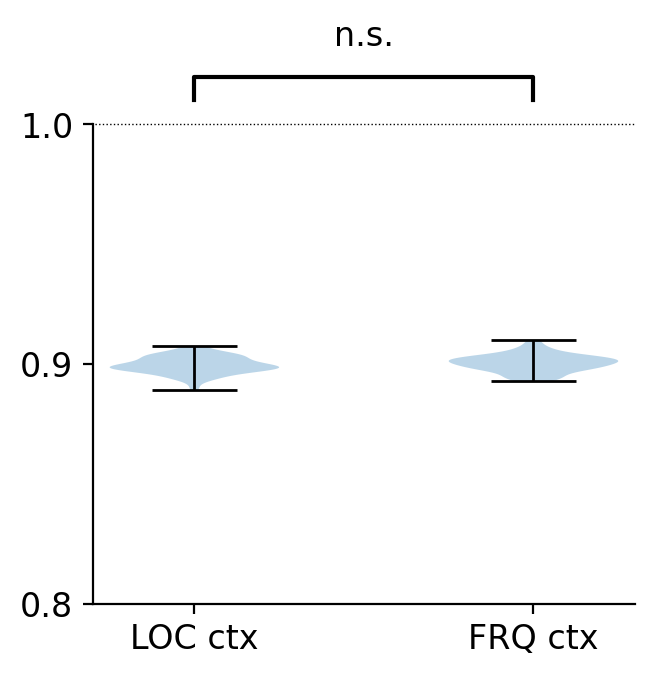

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

parts = ax.violinplot([sim_sv_choice[:, 0], sim_sv_choice[:, 1]])

# Set line color to black
for key in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if key in parts:
        parts[key].set_edgecolor('black')
        parts[key].set_linewidth(1.)  # Set line width thicker if needed

# ax.set_ylim(-0.0, 1.01)
ax.spines[["right", "top"]].set_visible(False)
ax.set_xticks([1, 2])
ax.plot([0.5, 2.5], [1, 1], "k:", lw=0.5)
ax.set_xlim(0.7, 2.3)

# Position and offset settings
y_max = 1.01
height = 0.01
line_width = 1.5
text_offset = 0.01

# Add significance marker and bracket
# Between 1 and 2
x1, x2 = 1, 2
y, h, col = y_max, height, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "n.s.", ha='center', va='bottom', color=col, fontsize=12)

# Set axis display range, shorten axis length
ax.spines['left'].set_bounds(0.8, 1.0)  # Limit y-axis display range

# Adjust y-axis ticks and labels
ax.set_ylim(0.8, 1.025)  # Allow significance marker to be displayed outside the axis
ax.set_yticks([0.8, 0.9, 1.0])

ax.set_xticklabels(["LOC ctx", "FRQ ctx"])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("cos angle between sv and choice", format="pdf")

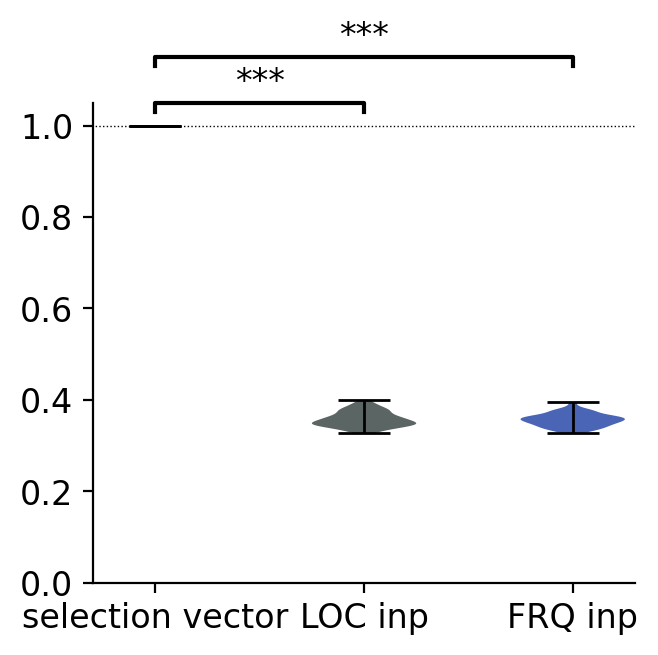

In [25]:
# Figure 2C

fig, ax = plt.subplots(figsize=(3.5, 3.5))

parts = ax.violinplot([sim_sv, sim_I[:, 0], sim_I[:, 1]])

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor((["#57BD49"] + mod_color)[i])
    pc.set_edgecolor('none')
    pc.set_alpha(1)

# Set line color to black
for key in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if key in parts:
        parts[key].set_edgecolor('black')
        parts[key].set_linewidth(1.)  # Set line width thicker if needed

# ax.set_ylim(-0.0, 1.01)
ax.spines[["right", "top"]].set_visible(False)
ax.set_xticks([1, 2, 3])
ax.plot([0.5, 3.5], [1, 1], "k:", lw=0.5)
ax.set_xlim(0.7, 3.3)

# Position and offset settings
y_max = 1.03
height = 0.02
line_width = 1.5
text_offset = 0.01

# Add significance marker and bracket
# Between 1 and 2
x1, x2 = 1, 2
y, h, col = y_max, height, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col, fontsize=12)

# Between 1 and 3
x1, x2 = 1, 3
y, h, col = y_max + 0.1, height, 'k'  # y increased by 0.1 to avoid overlap
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col, fontsize=12)

# Set axis display range, shorten axis length
ax.spines['left'].set_bounds(0, 1.05)  # Limit y-axis display range

# Adjust y-axis ticks and labels
ax.set_ylim(0, 1.18)  # Allow significance marker to be displayed outside the axis
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_xticklabels(["selection vector", "LOC inp", "FRQ inp"])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("cos angle between ctx", format="pdf")

In [11]:
print(stats.ttest_ind(sim_sv_choice[:, 0], sim_sv_choice[:, 1]))
print(stats.ttest_ind(sim_sv_I[:, 0, 0], sim_sv_I[:, 0, 1]))
print(stats.ttest_ind(sim_sv_I[:, 1, 0], sim_sv_I[:, 1, 1]))

Ttest_indResult(statistic=-1.5822139421197137, pvalue=0.11519675958801302)
Ttest_indResult(statistic=454.5397415295947, pvalue=7.633189500880094e-301)
Ttest_indResult(statistic=-493.68959159254547, pvalue=6.085372597645282e-308)


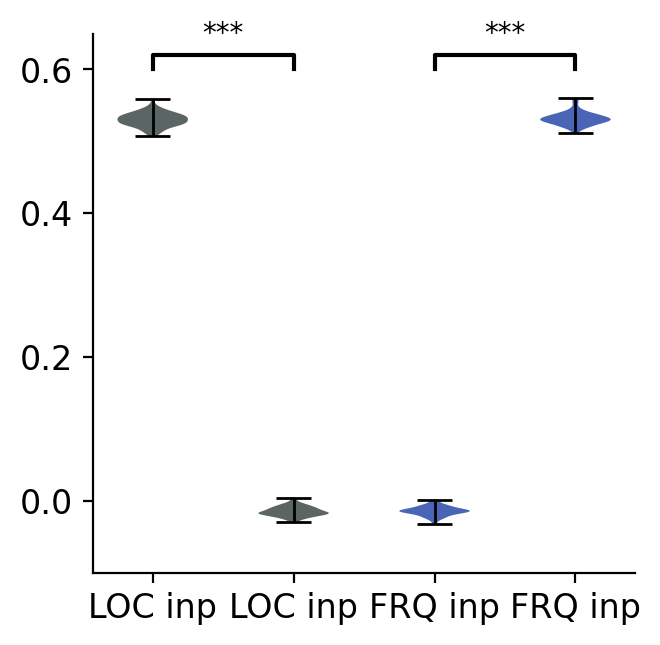

In [26]:
# Figure 2D

fig, ax = plt.subplots(figsize=(3.5, 3.5))

parts = ax.violinplot([sim_sv_I[:, 0, 0], sim_sv_I[:, 0, 1], sim_sv_I[:, 1, 0], sim_sv_I[:, 1, 1]])

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(mod_color[i//2])
    pc.set_edgecolor('none')
    pc.set_alpha(1)

# Set line color to black
for key in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if key in parts:
        parts[key].set_edgecolor('black')
        parts[key].set_linewidth(1.)  # Set line width thicker if needed

# # ax.set_ylim(-0.0, 1.01)
ax.spines[["right", "top"]].set_visible(False)
# ax.set_xticks([1,2,3])
# ax.plot([0.5, 3.5], [1,1], "k:", lw=0.5)
# ax.set_xlim(0.7, 3.3)

# Position and offset settings
y_max = 0.6
height = 0.02
line_width = 1.5
text_offset = 0.01

# Add significance marker and bracket
# Between 1 and 2
x1, x2 = 1, 2
y, h, col = y_max, height, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col)

# Between 3 and 4
x1, x2 = 3, 4
y, h, col = y_max, height, 'k'  # y increased by 0.1 to avoid overlap
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col)

# # Set axis display range, shorten axis length
# ax.spines['left'].set_bounds(0, 1.05)  # Limit y-axis display range

# Adjust y-axis ticks and labels
ax.set_ylim(-0.1, 0.65)  # Allow significance marker to be displayed outside the axis
ax.set_yticks([0, 0.2, 0.4, 0.6])

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["LOC inp", "LOC inp", "FRQ inp", "FRQ inp"])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("cos angle between xx and selection vector", format="pdf")

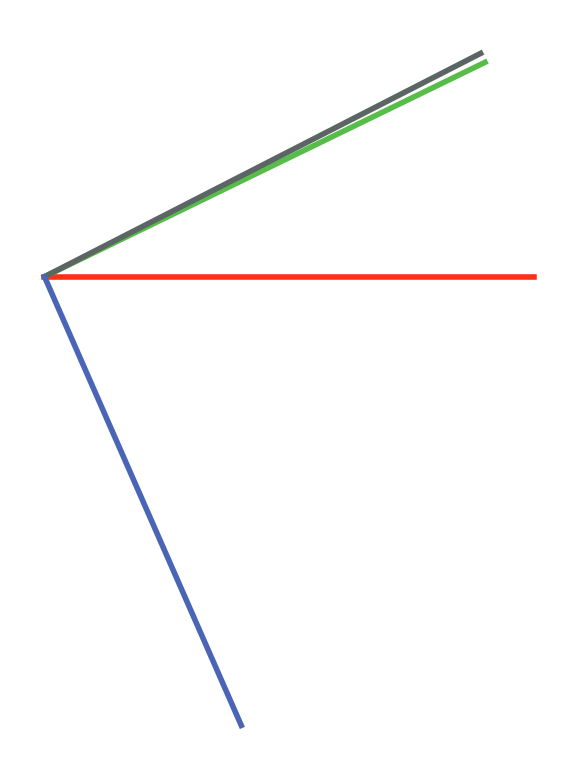

In [ ]:
# Figure 2E

fig, ax = plt.subplots()

loaded = all_loaded[-1]

ref = torch.linalg.qr(torch.stack([loaded["choice"][0], loaded["sv"][0]], 1)).Q
ref[:, 1] = -ref[:, 1]

choice_ref = (loaded["choice"][0].view(1, -1) @ ref).squeeze()
sv_ref = (loaded["sv"][0].view(1, -1) @ ref).squeeze()
I1_ref = (loaded["I"][0][0].view(1, -1) @ ref).squeeze()
I2_ref = (loaded["I"][1][0].view(1, -1) @ ref).squeeze()

def normalize(x):
    return x / x.norm()

I1_ref = normalize(I1_ref)
I2_ref = normalize(I2_ref)

lw=2

ax.plot([0, choice_ref[0]], [0, choice_ref[1]], color="#FF3017", lw=lw)
ax.plot([0, sv_ref[0]], [0, sv_ref[1]], color="#57BD49", lw=lw)
ax.plot([0, I1_ref[0]], [0, I1_ref[1]], color=mod_color[0], lw=lw)
ax.plot([0, I2_ref[0]], [0, I2_ref[1]], color=mod_color[1], lw=lw)

ax.set_aspect("equal")
ax.axis("off")

save_figure("geometry motion ctx", format="pdf")

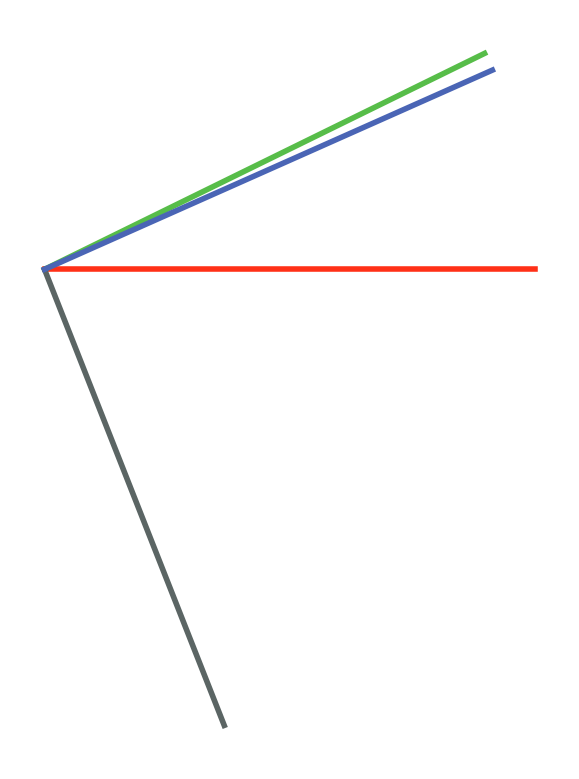

In [14]:
fig, ax = plt.subplots()

ref = torch.linalg.qr(torch.stack([loaded["choice"][1], loaded["sv"][1]], 1)).Q
ref[:, 1] = -ref[:, 1]

choice_ref = (loaded["choice"][1].view(1, -1) @ ref).squeeze()
sv_ref = (loaded["sv"][1].view(1, -1) @ ref).squeeze()
I1_ref = (loaded["I"][0][1].view(1, -1) @ ref).squeeze()
I2_ref = (loaded["I"][1][1].view(1, -1) @ ref).squeeze()

def normalize(x):
    return x / x.norm()

I1_ref = normalize(I1_ref)
I2_ref = normalize(I2_ref)

ax.plot([0, choice_ref[0]], [0, choice_ref[1]], color="#FF3017", lw=lw)
ax.plot([0, sv_ref[0]], [0, sv_ref[1]], color="#57BD49", lw=lw)
ax.plot([0, I1_ref[0]], [0, I1_ref[1]], color=mod_color[0], lw=lw)
ax.plot([0, I2_ref[0]], [0, I2_ref[1]], color=mod_color[1], lw=lw)

ax.set_aspect("equal")
ax.axis("off")

save_figure("geometry color ctx", format="pdf")

In [15]:
@torch.no_grad()
def get_acc(rnn, repeat=100):
    acc = list()
    prob_right = list()
    for r in range(repeat):
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input()
        h = rnn(spike_input.to(device), noise_inp=0)
        f = rnn.phi(h)
        output = rnn.outputs(f)
        acc.append(((output[:, -1, :] * y[:, -1, :]) > 0).float())
        prob_right.append((output[:, -1, :] > 0).float())
    return torch.cat(acc, 1), torch.cat(prob_right, 1)

In [16]:
acc = list()
prob_right = list()
for l in tqdm(all_loaded):
    rnn = l["rnn"].to(device)
    a, p = get_acc(rnn, repeat=100)
    acc.append(a.mean(1))
    prob_right.append(p.mean(1))
acc = torch.stack(acc, 0)
prob_right = torch.stack(prob_right, 0)

100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


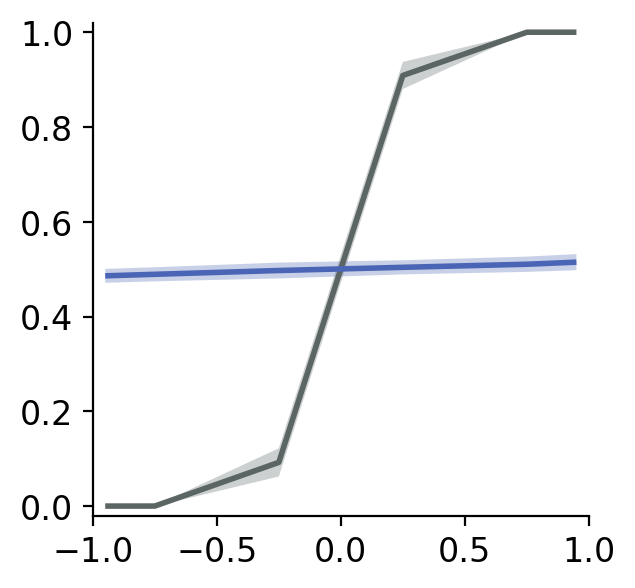

In [ ]:
# Figure 2B, left

fig, ax = plt.subplots(figsize=(3.2, 3.2))

pr = prob_right.reshape(-1, 2, 6, 6)

for c in range(2):
    mean_pr = pr[:, c].mean(2).mean(0)
    std_pr = pr[:, c].mean(2).std(0)
    ax.plot(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr), color=mod_color[c], lw=2, solid_capstyle="butt")
    ax.fill_between(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr - 1.96 * std_pr), tn(1 - mean_pr + 1.96 * std_pr),
                   color=mod_color[c], alpha=0.3, edgecolor="none")
    
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.02, 1.02)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("prob right motion", format="pdf")

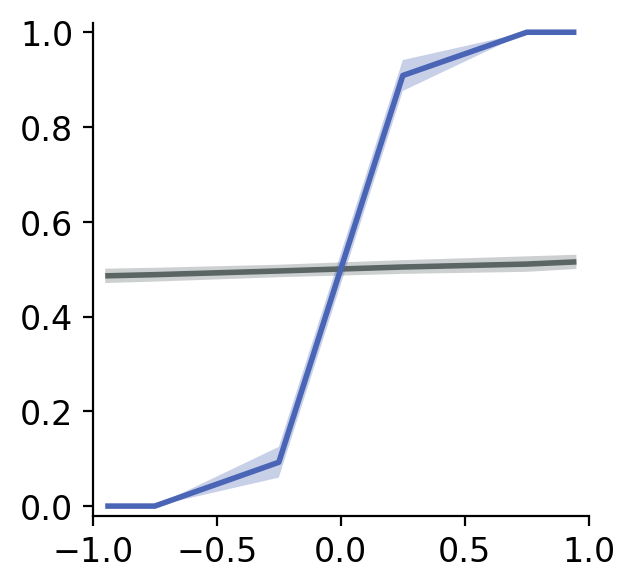

In [ ]:
# Figure 2B, right

fig, ax = plt.subplots(figsize=(3.2, 3.2))

pr = prob_right.reshape(-1, 2, 6, 6)

for c in range(2):
    mean_pr = pr[:, c].mean(1).mean(0)
    std_pr = pr[:, c].mean(1).std(0)
    ax.plot(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr), color=mod_color[c], lw=2, solid_capstyle="butt")
    ax.fill_between(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr - 1.96 * std_pr), tn(1 - mean_pr + 1.96 * std_pr),
                   color=mod_color[c], alpha=0.3, edgecolor="none")
    
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.02, 1.02)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("prob right loc", format="pdf")

In [19]:
@torch.no_grad()
def calculate_state_space_kernel(rnn, reg:float=0, repeat:int=100, hz:float=1, device=device)->torch.Tensor:
    N = rnn.x_dim()
    batch_size = 500
    K = 40 * 4 + 40 + 2
    xtx = torch.zeros(K, K)
    xty = torch.zeros(K, N)

    for ctx in range(2):
        for i in trange(repeat):
            spike_input = get_random_input(batch_size, ctx=ctx, hz=hz, device=device, fixed_t=10)
            init_state = rnn._I[:, 2+ctx].view(1, -1)
            h = rnn(spike_input, noise_inp=0, noise_rec=0, init_state=init_state)
            f = rnn.phi(h)
            z = rnn.outputs(f)
            f = f[:, 11:, :]
            bined_input_1 = spike_input[:, 10:, 0] * 10
            bined_input_2 = spike_input[:, 10:, 1] * 10
            design_x = torch.zeros(batch_size, 40, K)
            design_y = torch.zeros(batch_size, 40, N)
            for t in range(40):
                design_x[:, t, 80*ctx:80*ctx + t + 1] = bined_input_1[:, :t + 1].flip(1).cpu()
                design_x[:, t, 80*ctx+40:80*ctx + t + 41] = bined_input_2[:, :t + 1].flip(1).cpu()
                design_x[:, t, 160+t] = 1
                design_x[:, t, 200] = ctx
                design_x[:, t, 201] = (z[:, -1, 0] > 0).float()
                design_y[:, t] = f[:, t, :]
            design_x = design_x.reshape(-1, design_x.shape[-1])
            design_y = design_y.reshape(-1, design_y.shape[-1])
            xtx += design_x.T @ design_x # 21, 21
            xty += design_x.T @ design_y # 21, N

    return xtx, torch.inverse(xtx + reg * torch.eye(design_x.shape[-1]).type_as(xtx)) @ xty # 21, N

In [20]:
def positive_qr(x):
    Q, R = torch.linalg.qr(x)
    for i in range(R.shape[0]):
        if R[i, i] < 0:
            R[i, :] = -R[i, :]
            Q[:, i] = -Q[:, i]
    return Q, R

In [21]:
@torch.no_grad()
def calculate_tdr(rnn, repeat:int=100, reg=0, order=0)->torch.Tensor:
    N = rnn.x_dim()
    xtx = torch.zeros(5, 5).to(device)
    xty = torch.zeros(5, 51, N).to(device)

    if order == 0:
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
        design_x = torch.ones(72, 5).to(device)
        design_x[:, 3] = ctx # context
        design_x[:, 0] = y[:, 0, 0] # choice
        for b in range(72):
            design_x[b, 1] = [38/40, 30/40, 10/40, -10/40, -30/40, -38/40][cnds[b, 0]]
            design_x[b, 2] = [38/40, 30/40, 10/40, -10/40, -30/40, -38/40][cnds[b, 1]]
    elif order == 1:
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
        design_x = torch.ones(72, 5).to(device)
        design_x[:, 0] = ctx # context
        design_x[:, 1] = y[:, 0, 0] # choice
        for b in range(72):
            design_x[b, 2] = [38/40, 30/40, 10/40, -10/40, -30/40, -38/40][cnds[b, 0]]
            design_x[b, 3] = [38/40, 30/40, 10/40, -10/40, -30/40, -38/40][cnds[b, 1]]

    for i in trange(repeat):
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
        h = rnn(spike_input, noise_inp=0, noise_rec=0)
        f = rnn.phi(h)
        xtx += design_x.T @ design_x
        xty += torch.einsum("br,btn->rtn", design_x, f)
    return torch.einsum("ir,rtn->itn", torch.inverse(xtx + reg * torch.eye(design_x.shape[-1]).type_as(xtx)), xty)

In [22]:
beta_time = calculate_tdr(rnn, order=0)
beta = torch.zeros(5, beta_time.shape[-1]).to(device)
for b in range(5):
    time_index = beta_time[b].norm(dim=1).max(dim=0).indices.item()
    beta[b, :] = beta_time[b, time_index, :]
beta0, R = positive_qr(beta.T)
print(R)

100%|██████████| 100/100 [00:01<00:00, 51.48it/s]


tensor([[ 6.10,  1.07,  1.02, -0.25,  0.06],
        [ 0.00,  2.73, -1.73,  0.18,  0.05],
        [-0.00, -0.00,  2.10,  1.89, -0.81],
        [-0.00, -0.00, -0.00, 18.08, -8.83],
        [-0.00, -0.00, -0.00, -0.00,  8.87]], device='cuda:4')


In [23]:
f = 0
n_repeat = 500
with torch.no_grad():
    for r in trange(n_repeat):
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
        h = rnn(spike_input, noise_inp=0, noise_rec=0)
        f = f + rnn.phi(h)
f = f / n_repeat

100%|██████████| 500/500 [00:09<00:00, 50.53it/s]


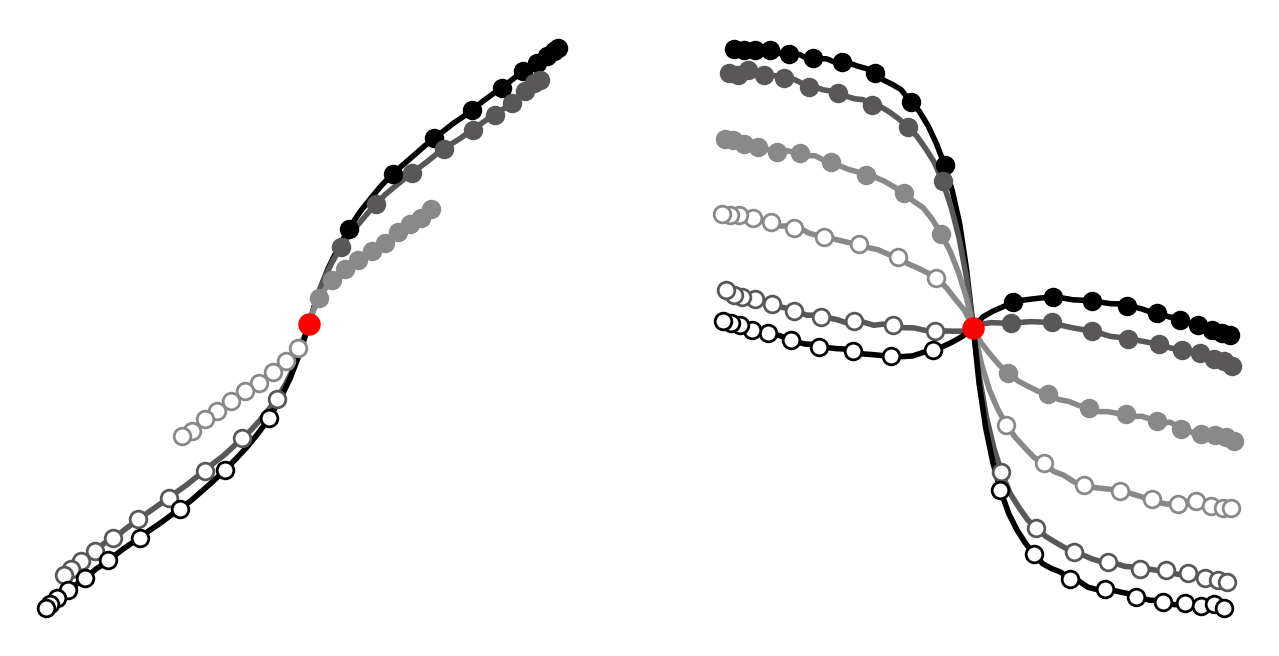

In [28]:
# Figure 2F

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

tad = (f @ beta0) # choice, loc, frq, context, constant

ax = axs[0]

ts = vector.range(4, 41, 4)

y = tad.reshape(2, 6, 6, 51, 5)[0].mean(1)
for b in range(6):
    yt = y[b, 10:, :]
    color = ["#000000", "#595757", "#898989", "#898989", "#595757", "#000000"][b]
    ax.plot(tn(yt[:, 0]), tn(yt[:, 1]), color=color, lw=2)
    ax.scatter(tn(yt[ts, 0]), tn(yt[ts, 1]), edgecolor=color, facecolor=[color, "w"][b>=3], zorder=10)
ax.axis("off")    
ax.scatter(tn(yt[0, 0]), tn(yt[0, 1]), s=50, color="r", zorder=100)
    
ax = axs[1]

y = tad.reshape(2, 6, 6, 51, 5)[1]
for b in range(6):
    color = ["#000000", "#595757", "#898989", "#898989", "#595757", "#000000"][b]
    yt = y[b, :3, 10:, :].mean(0)
    ax.plot(tn(yt[:, 0]), tn(yt[:, 1]), color=color, lw=2)
    ax.scatter(tn(yt[ts, 0]), tn(yt[ts, 1]), edgecolor=color, facecolor=[color, "w"][b>=3], zorder=10)
    yt = y[b, 3:, 10:, :].mean(0)
    ax.plot(tn(yt[:, 0]), tn(yt[:, 1]), color=color, lw=2)
    ax.scatter(tn(yt[ts, 0]), tn(yt[ts, 1]), edgecolor=color, facecolor=[color, "w"][b>=3], zorder=10)
ax.axis("off")
ax.scatter(tn(yt[0, 0]), tn(yt[0, 1]), s=50, color="r", zorder=100)

save_figure("trial_averaged_dynamics", format="pdf")